# Linear Regression and Nearby Features (Distance and Bearing)

### Dataset Preprocessing

Dataset preprocessing is a result from the analysis undertook in the EDA file. Changes include:

1. Decomposing the valid_time datetime field into component features (year, month, day, hour) and deriving a seasonal indicator to capture cyclical weather patterns.

2. ID Removal: Removed the ID field as it contained no predictive information.  

After creating the distributive dataset further preprocessing was completed (this time seperate to specific model files but still the same principles employed):

1. One-Hot Encoding Application: This encoding was applied to features with complicated ordering. Specifically, one-hot encoding was applied to: 

    Years: due to only two years of data being provided it made sense to split them accordingly. This data could have been kept as standard numerical values given a wider range of years. 

    Seasons, Months, Days and Hours: due to their cyclical nature; i.e. we wouldn’t our model to learn that Dec (12) and Jan as (1) are numerically far apart even though they are actually very close to each other. 

    Precipitation Type (ptype): due to the lack of inherent ordering in types. 

2. Numerical Feature Processing: For continuous variables, applied median-based imputation to handle any missing values, followed by standardisation to ensure all features contributed equally to model training regardless of their original scales. 



In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
era5_train = pd.read_csv("train.csv", sep=",") # Loading training dataset
era5_train, era5_validation = train_test_split(era5_train, test_size=0.2, random_state=RANDOM_SEED) # Splitting with set seed

In [15]:
# Defining function to calculate distance from a reference point
def calcDistance(row, reference_point):
    point = (row['latitude'], row['longitude'])
    return geodesic(point, reference_point).kilometers

# Defining function calculate bearing between two points
def calcBearing(row, reference_point):
    lat1, lon1 = np.radians(reference_point)  # Reference point (convert to radians)
    lat2, lon2 = np.radians((row['latitude'], row['longitude']))  # Data point (convert to radians)

    lon_diff = lon2 - lon1  # Difference in longitudes

    # Calculating bearing
    x = np.sin(lon_diff) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_diff)

    # Convert bearing from radians to degrees
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360 # Return normalised bearing in range [0, 360]

### Nearby Features

Nearby features were developed spatially - a central point was defined from the training data and distances/bearings from this point were calculated between all other instances in the training dataset.

In [13]:
# Calculating the central point (mean latitude and mean longitude)
central_latitude = era5_train['latitude'].mean()
central_longitude = era5_train['longitude'].mean()

# Displaying  central point (latitude, longitude)
print(f"Central Latitude: {central_latitude}")
print(f"Central Longitude: {central_longitude}")

central_point = (central_latitude, central_longitude) # Setting central point

Central Latitude: 54.50017150095719
Central Longitude: -2.999218404317281


In [17]:
# Defining function for extracting temporal features
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] & 12 + 3) // 3) + 1
    return data

# Defining function for fully preparing data
def prepareData(data, reference_point):
    data.drop(["id"], axis = 1, inplace = True) # Removing id

    data["valid_time"] = pd.to_datetime(data["valid_time"]) # Convert valid_time to suitable format
    data = convertDateTimeToComponents(data, "valid_time")  # Create columns from valid_time
    data.drop(["valid_time"], axis = 1, inplace = True) # Removing valid_time

    data["distance_to_center"] = data.apply(calcDistance, axis=1, reference_point=reference_point) # Calculating distance from points to center point
    data["bearing_to_center"] = data.apply(calcBearing, axis=1, reference_point=reference_point) # Calculating point bearing from center point
    return data

# Preparing datasets
prepareData(era5_train, central_point)
prepareData(era5_validation, central_point)

### Exporting/Loading Datasets
Dataset saving for distribution to other group members
Datasets when preprocessing has already been completed and datasets already saved

In [41]:
# Saving fully prepared data WITH NEARBY FEATURES
era5_train.to_csv('era5_train_prepared_with_nearby.csv', index=False)
era5_validation.to_csv('era5_val_prepared_with_nearby.csv', index=False)
print("Datasets saved successfully!")

Datasets saved successfully!


In [3]:
# Reading data WITH nearby features
era5_train = pd.read_csv("era5_train_prepared_with_nearby.csv", sep=",")
era5_validation = pd.read_csv("era5_val_prepared_with_nearby.csv", sep=",")

# Dropping nearby features to create a dataset WITHOUT nearby features for use across models and for nearby feature comparison in this code
era5_train_base = era5_train.drop(["distance_to_center", "bearing_to_center"], axis=1)
era5_validation_base = era5_validation.drop(["distance_to_center", "bearing_to_center"], axis=1)

In [4]:
# Saving fully prepared data WITHOUT nearby features for distribution
era5_train_base.to_csv('era5_train_prepared_with_no_nearby.csv', index=False)
era5_validation_base.to_csv('era5_val_prepared_with_no_nearby.csv', index=False)
print("Datasets saved successfully!")

Datasets saved successfully!


In [5]:
# Assessing attributes of datasets with and without nearby features
attributes = list(era5_train.columns)
attributes_base = list(era5_train_base.columns)

one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))
numerical_attributes_base = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes_base))

print(one_hot_attributes)
print(numerical_attributes)
print(numerical_attributes_base)

['year', 'month', 'day', 'hour', 'season', 'ptype']
['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc', 'distance_to_center', 'bearing_to_center']
['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc']


In [7]:
era5_train.head()

,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m,year,month,day,hour,season,distance_to_center,bearing_to_center
0,56.00,-0.75,0.000000,2.117569,8.345276,101296.94,3.671143,10.726196,0.398621,0.0,290.68433,2018,7,31,17,3,219.841409,39.603916
1,58.75,-5.75,0.000913,5.980820,9.166794,100456.50,8.365173,11.827179,1.000000,1.0,287.38440,2018,8,21,20,3,502.344343,341.542389
2,52.50,1.75,0.000000,-1.023087,3.779327,102173.44,-1.325638,5.412933,0.307495,0.0,278.67260,2018,2,17,10,1,385.713079,123.373683
3,52.00,1.25,0.000000,5.188187,1.900284,101178.25,7.420486,2.424911,1.000000,0.0,286.73853,2018,6,17,4,3,397.192084,132.801674
4,56.75,-6.75,0.000097,6.590653,-6.228958,100491.25,7.399139,-6.996277,0.369110,1.0,280.39430,2018,2,3,6,1,344.245396,318.268936


In [8]:
era5_validation.head()

,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m,year,month,day,hour,season,distance_to_center,bearing_to_center
0,51.25,-7.25,0.000000,5.886337,-0.648453,101456.500,6.440597,-0.707596,0.025299,0.0,283.53760,2018,5,13,4,2,461.058657,219.998519
1,52.50,-3.75,0.000005,-4.333618,1.897888,99209.440,-7.078690,3.492432,1.000000,1.0,283.28590,2018,11,16,22,4,228.113667,192.888681
2,54.25,-2.25,0.000171,-1.242538,-1.477005,96517.000,-1.713867,-2.030670,1.000000,7.0,274.53480,2018,2,3,16,1,56.088494,119.519012
3,50.00,-3.75,0.000000,-7.468582,-4.135788,102921.375,-9.300003,-4.978210,0.599976,0.0,288.54736,2018,9,28,19,4,503.353117,186.130499
4,55.75,-3.25,0.000000,-2.917770,2.137604,99554.560,-4.929230,4.259506,0.148224,6.0,273.70874,2018,2,25,9,1,140.054683,353.557775


### Encoding Data
Here we encode data in preparation for passing to our model - the same methods are applied across other notebooks (but with a slightly varying pipeline due to other models utilising different methods of nearby features).

In [9]:
# Defining function for encoding data for machine learning
def encodeData(data, oh_attributes, n_attributes):
    x = data.drop("t2m", axis=1)
    y = data["t2m"]

    # Setting one-hot pipeline strategy
    onehot_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder())
    ])

    # Setting pipeline for numerical scaling
    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    transformers = [
        ("cat-onehot", onehot_pipeline, oh_attributes),
        ("numerical", numerical_pipeline, n_attributes)
    ]

    full_pipeline = ColumnTransformer(transformers=transformers)
    x_prepared = full_pipeline.fit_transform(x)
    return x_prepared, y

# Encoding data for with and without nearby features
x_train, y_train = encodeData(era5_train, one_hot_attributes, numerical_attributes)
x_validation, y_validation = encodeData(era5_validation, one_hot_attributes, numerical_attributes)

x_train_base, y_train_base = encodeData(era5_train_base, one_hot_attributes, numerical_attributes_base)
x_validation_base, y_validation_base = encodeData(era5_validation_base, one_hot_attributes, numerical_attributes_base)

### Grid Search Hyper-Parameter Tuning

Grid search with cross validation was employed to fine tune model hyperparameters.

In [11]:
model = LinearRegression() # Defining model

# Setting parameter grid
param_grid = {'copy_X': [True,False],
              'fit_intercept': [True,False],
              'n_jobs': [1,5,10,15,None],
              'positive': [True,False]}

grid_search = GridSearchCV(model, param_grid, cv=5) # Performing grid search

grid_search.fit(x_train, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Best Score: 0.7616337090343517


### Training Model with Best Parameters

Linear regression models were trained using datasets with and without nearby features

In [22]:
linear_regression = LinearRegression(**best_parameters)
linear_regression.fit(x_train, y_train)

LinearRegression(n_jobs=1)

In [23]:
linear_regression_base = LinearRegression(**best_parameters)
linear_regression_base.fit(x_train_base, y_train_base)

LinearRegression(n_jobs=1)

### Saving Models

In [33]:
joblib.dump(linear_regression, 'linear_regression.pkl')
print("Model saved successfully!")

joblib.dump(linear_regression_base, 'linear_regression_base.pkl')
print("Model saved successfully!")

Model saved successfully!
Model saved successfully!


Loading models (if needed)

In [10]:
linear_regression = joblib.load('linear_regression.pkl')
linear_regression_base = joblib.load('linear_regression_base.pkl')

### Predictions
Making predictions with both models on the validation set and evaluating performances to decide which model will be taken to the next stage.

In [12]:
y_train_pred = linear_regression.predict(x_train)
y_train_pred_base = linear_regression_base.predict(x_train_base)

y_validation_pred = linear_regression.predict(x_validation)
y_validation_pred_base = linear_regression_base.predict(x_validation_base)

In [18]:
def evaluate(y_train, y_train_pred, y_validation, y_validation_pred, desc):

    print(f"\n\t{desc}")
    print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_validation, y_validation_pred)):.4f}")

    # find r2 score
    print(f"\nTraining R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Validation R²: {r2_score(y_validation, y_validation_pred):.4f}")

    # find mae
    print(f"\nTraining MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
    print(f"Validation MAE: {mean_absolute_error(y_validation, y_validation_pred):.4f}")

evaluate(y_train, y_train_pred, y_validation, y_validation_pred, "Model with Nearby Features")
evaluate(y_train_base, y_train_pred_base, y_validation_base, y_validation_pred_base, "Model without Nearby Features")


	Model with Nearby Features
Training RMSE: 2.3845
Validation RMSE: 2.3846

Training R²: 0.7632
Validation R²: 0.7630

Training MAE: 1.7875
Validation MAE: 1.7866

	Model without Nearby Features
Training RMSE: 2.3923
Validation RMSE: 2.3924

Training R²: 0.7616
Validation R²: 0.7614

Training MAE: 1.7958
Validation MAE: 1.7950


It can be observed in both models that we are unlikely to be overfitting, given that our scores for both training and validation sets are close. Based on these results, the model with nearby features. The model with nearby features performs slightly better than the one without.

### Assessment from Plotting

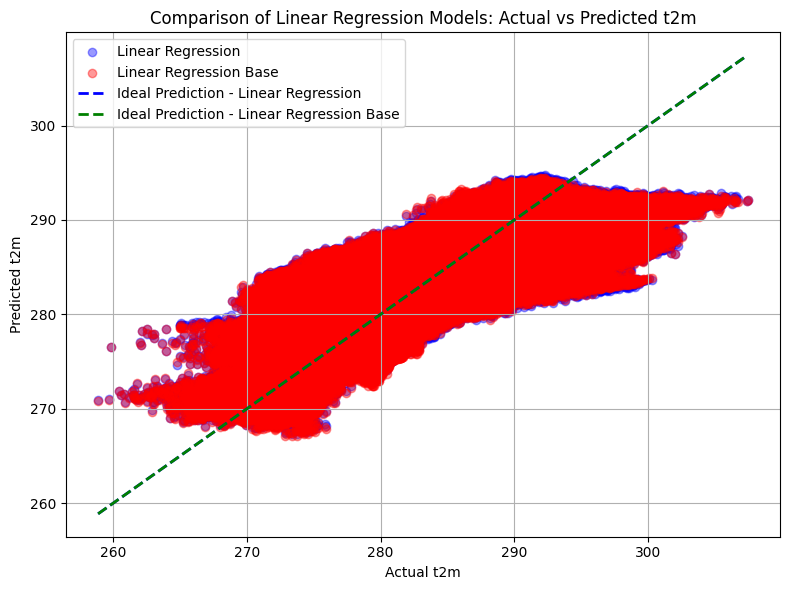

In [40]:
# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot for linear_regression predictions
plt.scatter(y_validation, y_validation_pred, alpha=0.4, label="Linear Regression", color='blue')

# Scatter plot for linear_regression_base predictions
plt.scatter(y_validation_base, y_validation_pred_base, alpha=0.4, label="Linear Regression Base", color='red')

# Ideal prediction line for Linear Regression (blue)
plt.plot([y_validation.min(), y_validation.max()],
         [y_validation.min(), y_validation.max()],
         color="blue", linestyle="--", linewidth=2, label="Ideal Prediction - Linear Regression")

# Ideal prediction line for Linear Regression Base (green)
plt.plot([y_validation_base.min(), y_validation_base.max()],
         [y_validation_base.min(), y_validation_base.max()],
         color="green", linestyle="--", linewidth=2, label="Ideal Prediction - Linear Regression Base")

# Labels and title
plt.xlabel("Actual t2m")
plt.ylabel("Predicted t2m")
plt.title("Comparison of Linear Regression Models: Actual vs Predicted t2m")

# Adding legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

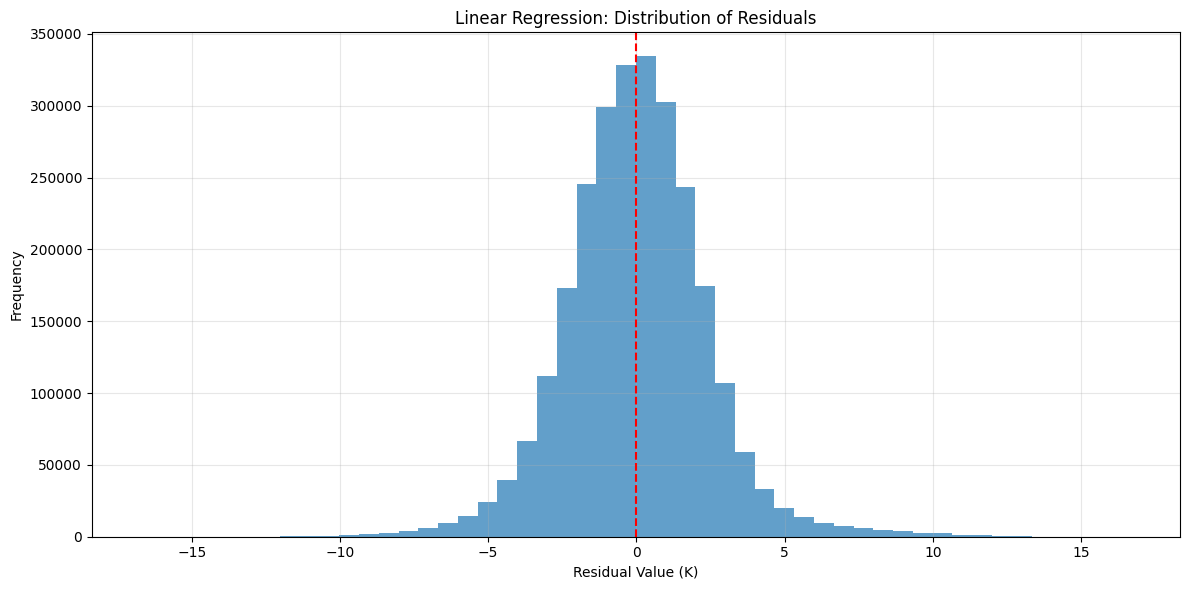

In [19]:
# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(y_validation - y_validation_pred.ravel(), bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value (K)')
plt.ylabel('Frequency')
plt.title('Linear Regression: Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Based on the histogram for the residuals we can see we are unlikely to be over-fitting based off the fact we have normal looking distribution

### Next Stage
Given that the model with nearby features integrated performed the best on the validation set, the predictions were saved to be compared in a separate file against other models predictions.

In [20]:
# Saving predictions for use in final evaluation file for comparison
np.savetxt('lr_y_train_predictions.csv',
           y_train_pred,
           delimiter=',',
           header='prediction',
           comments='')

# Save validation predictions
np.savetxt('lr_y_valid_predictions.csv',
           y_validation_pred,
           delimiter=',',
           header='prediction',
           comments='')